In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [2]:
df = pd.read_csv('data/data.csv')

## 1. Number of firms and observations

In [3]:
trend_co2 = df.groupby('year').Intensity_tot.mean().to_frame().reset_index(drop=False)
trend_co2['Co2_tot'] = df.groupby('year').Co2_tot.mean().values
trend_co2['year'] = pd.to_datetime(trend_co2['year'])

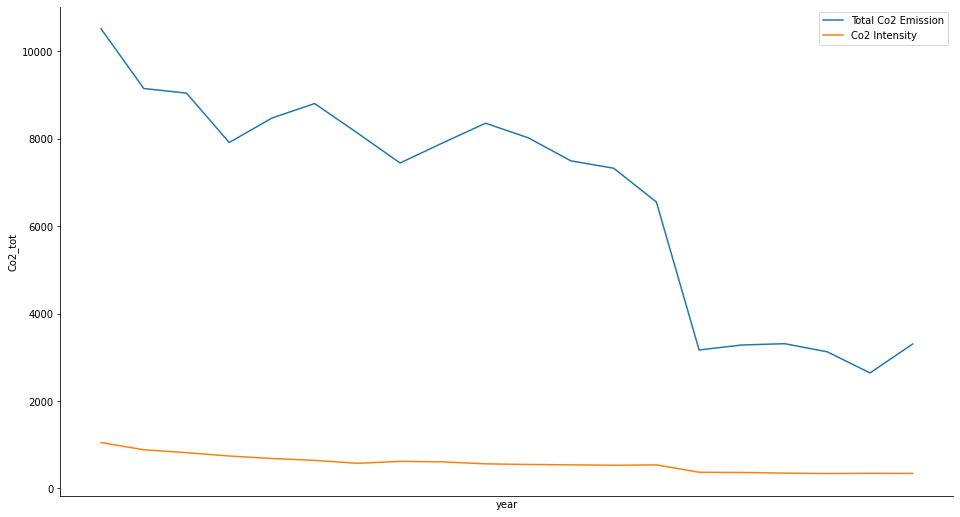

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.lineplot(x=trend_co2['year'], y=trend_co2['Co2_tot']/1000, ax=ax, label='Total Co2 Emission')
sns.lineplot(x=trend_co2['year'], y=trend_co2['Intensity_tot'], ax=ax, label='Co2 Intensity')

sns.despine()
plt.show()

## 2. Green and brown portfolios

### 2.1 Greenness based on co2 emission within industry

In [5]:
# compute weights
df['mc_sum'] = df.groupby(['year_month', 'greenness_co2_industry']).Marketcap.transform('sum')
df['weights'] = df.Marketcap / df.mc_sum

# value weighted returns
df['vw_return'] = df.RET * df.weights

# value weighted return for portfolios with different greenness
vw_return = df.groupby(['year_month', 'greenness_co2_industry'])['vw_return'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_wide = vw_return.pivot(index='year_month', columns='greenness_co2_industry', values='vw_return').reset_index()

vw_return_wide.columns = ['year_month', 'Green', 'A', 'Netrual', 'B', 'Brown']

vw_return_wide[['Green', 'A', 'Netrual', 'B', 'Brown']] = vw_return_wide[['Green', 'A', 'Netrual', 'B', 'Brown']].cumsum()
vw_return_wide['year_month'] = pd.to_datetime(vw_return_wide['year_month'], format='%Y-%m')

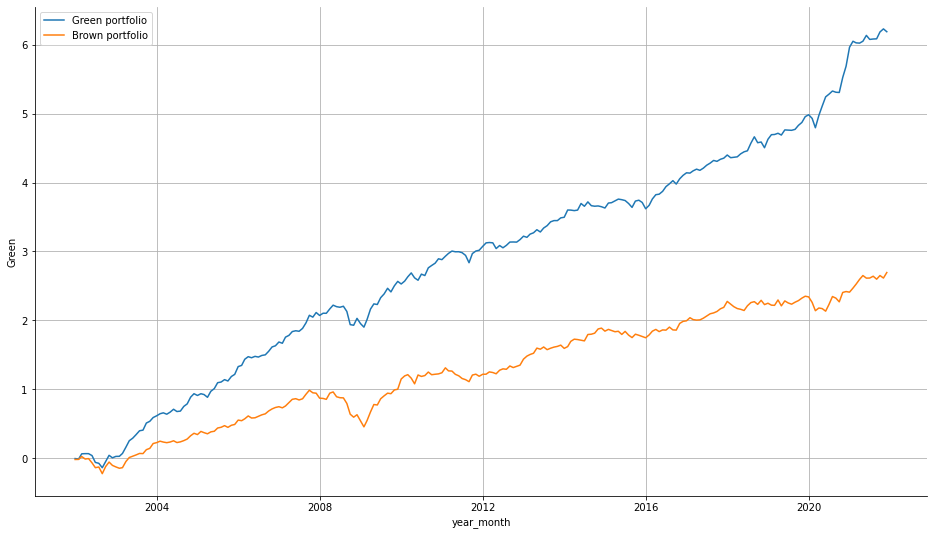

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.lineplot(data=vw_return_wide, x='year_month', y='Green', ax=ax, label='Green portfolio')
sns.lineplot(data=vw_return_wide, x='year_month', y='Brown', ax=ax, label='Brown portfolio')

plt.grid()
sns.despine()
plt.show()

### 2.2 Greenness based on carbon intensity whthin industry

In [7]:
# compute weights
df['mc_sum'] = df.groupby(['year_month', 'greenness_int_industry']).Marketcap.transform('sum')
df['weights'] = df.Marketcap / df.mc_sum

# value weighted returns
df['vw_return'] = df.RET * df.weights

# value weighted return for portfolios with different greenness
vw_return = df.groupby(['year_month', 'greenness_int_industry'])['vw_return'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_wide = vw_return.pivot(index='year_month', columns='greenness_int_industry', values='vw_return').reset_index()

vw_return_wide.columns = ['year_month', 'Green', 'A', 'Netural', 'B', 'Brown']

vw_return_wide[['Green', 'A', 'Netural', 'B', 'Brown']] = vw_return_wide[['Green', 'A', 'Netural', 'B', 'Brown']].cumsum()
vw_return_wide['year_month'] = pd.to_datetime(vw_return_wide['year_month'], format='%Y-%m')

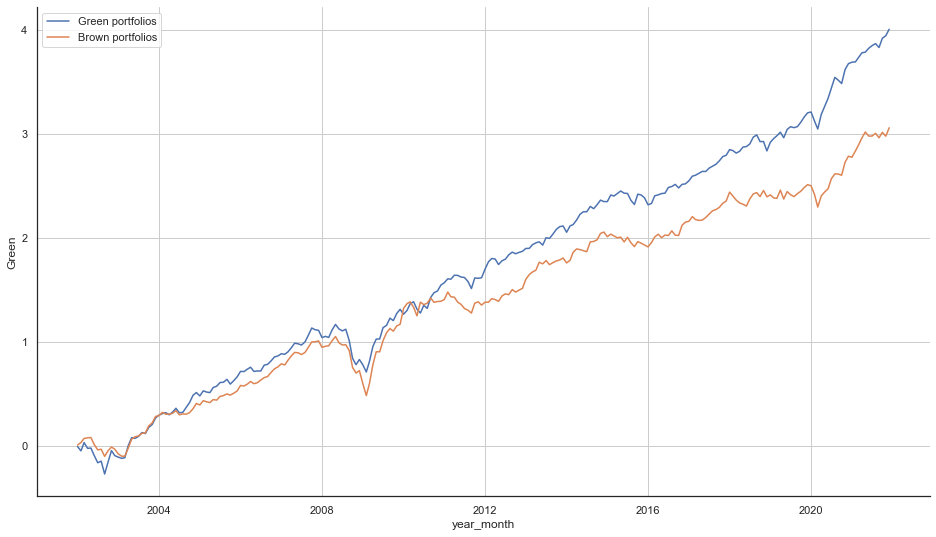

In [8]:
sns.set_theme(style='white')
fig, axe = plt.subplots(1,1, figsize=(16,9))

sns.lineplot(vw_return_wide, x='year_month', y='Green', label='Green portfolios')
sns.lineplot(vw_return_wide, x='year_month', y='Brown', label='Brown portfolios')

plt.grid()
sns.despine()

## 3. Industry Emission Ranking

In [11]:
industry = df.groupby('industry')['Co2_tot'].mean().to_frame()

industry = industry.reset_index()
industry = industry.sort_values('Co2_tot', ascending=False)

industry['rank'] = np.arange(1, len(industry) + 1)

industry['co2_total'] = industry['Co2_tot'].div(1000000).round(2)
industry = industry[['rank', 'industry', 'co2_total']]
industry.columns = ['Rank', 'GICS Industry Name', 'Total CO2 Emission']

In [12]:
industry_rank = pd.concat([industry[industry['Rank']<=33].reset_index(drop=True), industry[industry['Rank']>33].reset_index(drop=True)], axis=1).to_latex('analysis_result/industry_rank.tex', index=False)

In [13]:
# whole sample average CO2 emissions
df.Co2_tot.mean() / 1000000

5.427269051145981

In [14]:
# whole sample median CO2 emissions
df.Co2_tot.median() / 1000000

0.40187363282511407

## 4. Return distribution based on Co2 total


In [15]:
df['RET'] = df.RET * 100

In [16]:
df['percentiles'] = df.Co2_tot.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_tot = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Co2_scope1.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope1 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Co2_scope2.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope2 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Co2_scope3.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope3 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

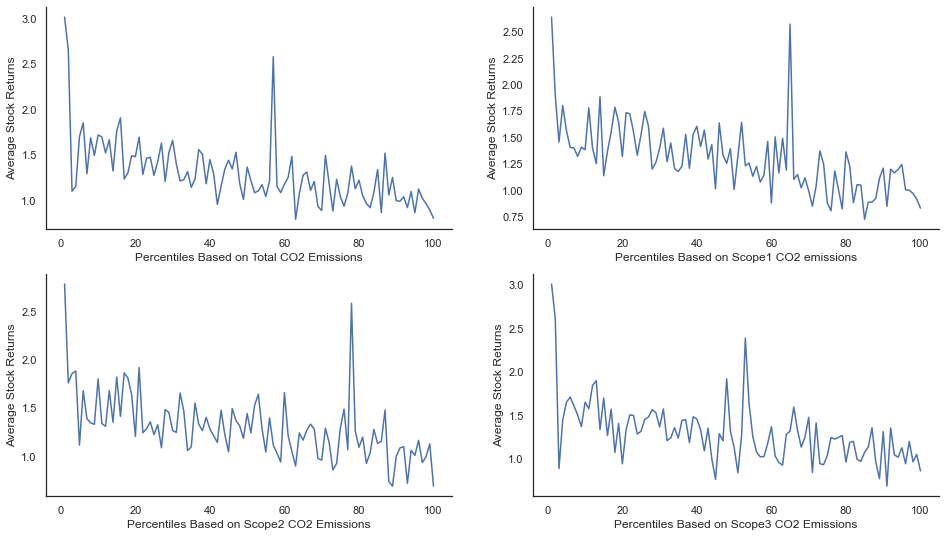

In [25]:
sns.set_theme(style='white')
fig, axe = plt.subplots(2,2, figsize=(16,9))

sns.lineplot(co2_tot, ax=axe[0,0], legend=False)
axe[0,0].set_xlabel('Percentiles Based on Total CO2 Emissions')
axe[0,0].set_ylabel('Average Stock Returns')

sns.lineplot(co2_scope1, ax=axe[0,1], legend=False)
axe[0,1].set_xlabel('Percentiles Based on Scope1 CO2 emissions')
axe[0,1].set_ylabel('Average Stock Returns')

sns.lineplot(co2_scope2, ax=axe[1,0], legend=False)
axe[1,0].set_xlabel('Percentiles Based on Scope2 CO2 Emissions')
axe[1,0].set_ylabel('Average Stock Returns')

sns.lineplot(co2_scope3, ax=axe[1,1], legend=False)
axe[1,1].set_xlabel('Percentiles Based on Scope3 CO2 Emissions')
axe[1,1].set_ylabel('Average Stock Returns')
sns.despine()

In [18]:
df['percentiles'] = df.Intensity_tot.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_tot = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope1.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope1 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope2.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope2 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope3.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope3 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

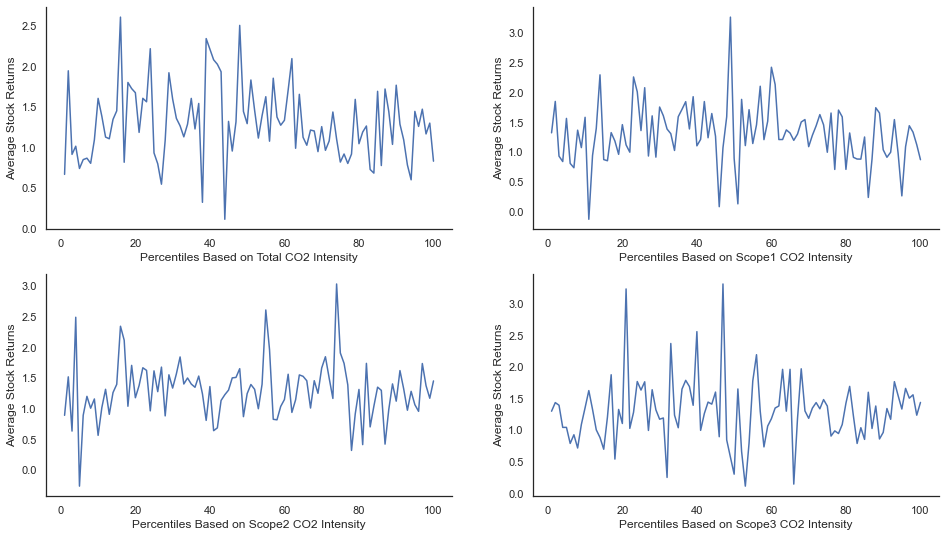

In [19]:
sns.set_theme(style='white')
fig, axe = plt.subplots(2,2, figsize=(16,9))

sns.lineplot(intensity_tot, ax=axe[0,0], legend=False)
axe[0,0].set_xlabel('Percentiles Based on Total CO2 Intensity')
axe[0,0].set_ylabel('Average Stock Returns')

sns.lineplot(intensity_scope1, ax=axe[0,1], legend=False)
axe[0,1].set_xlabel('Percentiles Based on Scope1 CO2 Intensity')
axe[0,1].set_ylabel('Average Stock Returns')

sns.lineplot(intensity_scope2, ax=axe[1,0], legend=False)
axe[1,0].set_xlabel('Percentiles Based on Scope2 CO2 Intensity')
axe[1,0].set_ylabel('Average Stock Returns')

sns.lineplot(intensity_scope3, ax=axe[1,1], legend=False)
axe[1,1].set_xlabel('Percentiles Based on Scope3 CO2 Intensity')
axe[1,1].set_ylabel('Average Stock Returns')
sns.despine()

In [20]:
df['percentiles'] = df.Marketcap.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
Marketcap = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Levarage.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
Levarage = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.RoE.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
RoE = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.SaleGR.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
SaleGR = df.groupby('percentiles', observed=True).RET.mean().to_frame()

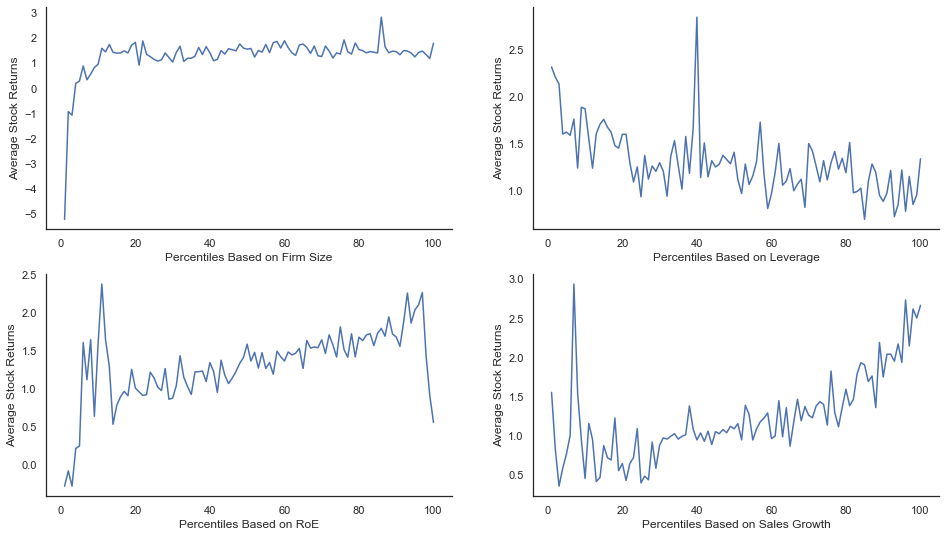

In [21]:
sns.set_theme(style='white')
fig, axe = plt.subplots(2,2, figsize=(16,9))

sns.lineplot(Marketcap, ax=axe[0,0], legend=False)
axe[0,0].set_xlabel('Percentiles Based on Firm Size')
axe[0,0].set_ylabel('Average Stock Returns')

sns.lineplot(Levarage, ax=axe[0,1], legend=False)
axe[0,1].set_xlabel('Percentiles Based on Leverage')
axe[0,1].set_ylabel('Average Stock Returns')

sns.lineplot(RoE, ax=axe[1,0], legend=False)
axe[1,0].set_xlabel('Percentiles Based on RoE')
axe[1,0].set_ylabel('Average Stock Returns')

sns.lineplot(SaleGR, ax=axe[1,1], legend=False)
axe[1,1].set_xlabel('Percentiles Based on Sales Growth')
axe[1,1].set_ylabel('Average Stock Returns')
sns.despine()

## 5. MCCC index

In [26]:
index_ = pd.read_csv('data/raw_data/index.csv')
index_['year_month'] = pd.PeriodIndex(index_.year_month, freq='M').astype(str)
index_['year_month'] = pd.to_datetime(index_['year_month'], format='%Y-%m')

# shift columns
col_shift = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix']
index_[col_shift] = index_[col_shift].shift(1)

index_['mccc_lag1'] = index_.mccc.shift(1)

# drop nas
index_.dropna(inplace=True)

# use ARC model to get umc
arx_model = sm.OLS.from_formula('mccc ~ 1 + mccc_lag1 + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=index_)
arx_fit = arx_model.fit()

index_['umc'] = index_.mccc - arx_fit.predict()

index_ = index_[['year_month', 'umc', 'mccc']].copy()

In [27]:
index_['cum_umc'] = index_.umc.cumsum()

<Axes: >

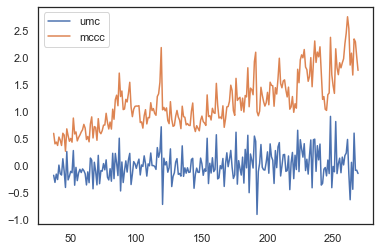

In [28]:
index_[['umc', 'mccc']].plot()